In [1]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertModel
# Load the CSV back into a new DataFrame (for later use)
#df = pd.read_csv(r'C:\Users\Sahan\Documents\Phase_4_Project\CSV\Hotel_Lem.csv')
#bert = pd.read_pickle(r'C:\Users\Sahan\Documents\Phase_4_Project\Embeddings\bert_embeddings.pkl')
df = pd.read_csv('Hotel_Lem.csv')
bert = pd.read_pickle('bert_embeddings.pkl')


In [2]:
# Ensure both DataFrames have the same index (if necessary)
bert = bert.reset_index(drop=True)
df = df.reset_index(drop=True)

# Concatenate the BERT embeddings with your main DataFrame
Bert_df = pd.concat([df, bert], axis=1)

# Verify the result
Bert_df

,HotelName,HotelRating,Address,City,State,Facilities,Cleaned_Text,Lemmatized_Text,0,1,...,758,759,760,761,762,763,764,765,766,767
0,Sunbelt Lodge Motel,2,1903 Veterans Memorial Drive AbbevilleLouisian...,Abbeville,Louisiana,shared loungetv area meetingbanquet facilities...,shared loungetv area meetingbanquet facilities...,shared loungetv area meetingbanquet facility w...,0.231322,0.306714,...,0.036324,-0.092945,-0.047764,-0.026186,0.295380,0.003586,-0.450574,-0.126786,-0.315632,-0.051949
1,Budget Inn & Suites,2,2115 Charity Street AbbevilleLouisiana 70510,Abbeville,Louisiana,24hour front desk nonsmoking rooms laundry fre...,hour front desk nonsmoking rooms laundry free ...,hour front desk nonsmoking room laundry free p...,0.376771,0.328142,...,-0.165577,-0.019288,-0.017614,-0.109886,0.150803,-0.079793,-0.448492,-0.099017,-0.352305,-0.034338
2,Best Western Abbeville Inn & Suites,2,3515 Veterans Memorial Dr Abbeville AbbevilleL...,Abbeville,Louisiana,wheelchair accessible may have limitations ven...,wheelchair accessible may limitations vending ...,wheelchair accessible may limitation vending m...,-0.133441,0.252630,...,0.079692,-0.310298,0.163278,0.060609,0.273035,-0.018295,-0.571709,-0.089511,-0.180690,-0.086050
3,Motel 6 Abbeville LA,2,3523 Veterans Memorial Drive AbbevilleLouisian...,Abbeville,Louisiana,wheelchair accessible may have limitations whe...,wheelchair accessible may limitations wheelcha...,wheelchair accessible may limitation wheelchai...,-0.243556,0.250552,...,-0.011533,-0.335915,-0.004612,0.114166,0.311642,-0.102268,-0.621948,-0.055168,-0.310393,-0.145939
4,Days Inn by Wyndham Abbeville,2,730 Veterans Memorial Dr AbbevilleLouisiana 70...,Abbeville,Louisiana,express checkout multilingual staff 24hour fro...,express checkout multilingual staff hour front...,express checkout multilingual staff hour front...,-0.192203,0.213387,...,0.021700,-0.167761,0.225822,0.114646,0.305736,0.050840,-0.637124,-0.121972,-0.202731,-0.014809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137943,Country Inn & Suites by Radisson Zion IL,2,1100 33Rd Street Zion 60099 ZionIllinois 60099,Zion,Illinois,dry cleaninglaundry service wheelchair accessi...,dry cleaninglaundry service wheelchair accessi...,dry cleaninglaundry service wheelchair accessi...,-0.059963,0.352325,...,0.000135,-0.275857,0.035998,0.203938,0.387492,-0.033887,-0.652356,-0.067724,-0.287671,-0.192961
137944,The Inn at Market Square,3,2723 Sheridan Road ZionIllinois 60099,Zion,Illinois,gift shops or newsstand shopping on site propo...,gift shops newsstand shopping site proposalrom...,gift shop newsstand shopping site proposalroma...,-0.051890,0.336202,...,-0.193763,-0.401766,0.045899,0.184396,0.260074,-0.143118,-0.642698,0.040746,-0.247167,-0.282319
137945,Best Western Plus Crossroads Inn & Suites,2,135 Wood Ridge Ter Zion Crossroads Zion Crossr...,Zion Crossroads,Virginia,daily safedeposit box at front desk smokefree ...,daily safedeposit box front desk smokefree pro...,daily safedeposit box front desk smokefree pro...,-0.067061,0.402882,...,0.085916,-0.290551,0.132355,0.116010,0.359201,-0.028135,-0.565618,-0.131658,-0.184061,-0.089842
137946,Zion Ponderosa Ranch Resort,2,Twin Knolls Road Zion National Park Orderville...,Zion National Park,Utah,mountain biking on site atmbanking terrace zip...,mountain biking site atmbanking terrace ziplin...,mountain biking site atmbanking terrace ziplin...,0.182542,0.274810,...,-0.059132,-0.052606,-0.199437,-0.065881,0.213055,-0.189100,-0.461603,-0.010514,-0.175378,-0.205878


In [4]:
marriot_hotels = df[df['HotelName'].str.contains('Marriot', case=False, na=False)]

# Group the Marriott hotels by 'HotelRating' and count the number of hotels in each rating
rating_counts = marriot_hotels['HotelRating'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title('Distribution of Marriott Hotels by Star Rating', fontsize=14)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Number of Hotels', fontsize=12)

# Show the plot
plt.xticks(rotation=0)  # Keeps the x-axis labels horizontal
plt.tight_layout()  # Adjusts layout to fit everything
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137948 entries, 0 to 137947
Columns: 776 entries, HotelName to 767
dtypes: float32(768), int64(1), object(7)
memory usage: 412.6+ MB


In [5]:
import torch
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Preprocessing
tfidf = TfidfVectorizer(max_features=500)  # Limit max_features if needed

# 2. Train-test split
X = df['Lemmatized_Text']  # Text features
y = df['HotelRating']  # Target variable

# Encoding labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encode target labels (5, 4, 3, 2, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# 3. Logistic Regression pipeline
lr_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', LogisticRegression(max_iter=10000, random_state=42))
])

# 4. Fit Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# 5. Predictions and classification report
lr_pred = lr_pipeline.predict(X_test)

# Fix for classification report: Map encoded labels back to their original string values
target_names = [str(rating) for rating in le.classes_]

# Print classification report for Logistic Regression
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_pred, target_names=target_names))

# 6. Extract top important words for Logistic Regression (per class)
lr_importances = lr_pipeline.named_steps['clf'].coef_  # shape: (n_classes, n_features)

# Get the feature names from the TF-IDF vectorizer
words_lr = np.array(tfidf.get_feature_names_out())

top_n = 10  # Define how many top words to show for each class

# For each class, sort and display the top important words
print("\nTop 10 Important Words for Logistic Regression (by class):")
for i, class_coef in enumerate(lr_importances):
    sorted_indices = np.argsort(class_coef)[::-1]  # Sort coefficients in descending order
    top_words_lr = words_lr[sorted_indices[:top_n]]
    top_importances_lr = class_coef[sorted_indices[:top_n]]

    print(f"\nClass {le.classes_[i]} (Rating {i+1}):")
    for word, importance in zip(top_words_lr, top_importances_lr):
        print(f"{word}: {importance}")

# 7. Extract least important words for Logistic Regression (per class)
print("\nLeast 10 Important Words for Logistic Regression (by class):")
for i, class_coef in enumerate(lr_importances):
    # Sort coefficients in ascending order (least important words will have the smallest values)
    sorted_indices = np.argsort(class_coef)  # Ascending order
    least_words_lr = words_lr[sorted_indices[:top_n]]
    least_importances_lr = class_coef[sorted_indices[:top_n]]

    print(f"\nClass {le.classes_[i]} (Rating {i+1}):")
    for word, importance in zip(least_words_lr, least_importances_lr):
        print(f"{word}: {importance}")


              precision    recall  f1-score   support

           1       0.91      0.38      0.53       489
           2       0.88      0.91      0.89     14623
           3       0.79      0.84      0.82     13352
           4       0.84      0.48      0.61      3700
           5       0.88      0.94      0.91      9221

    accuracy                           0.85     41385
   macro avg       0.86      0.71      0.75     41385
weighted avg       0.85      0.85      0.84     41385



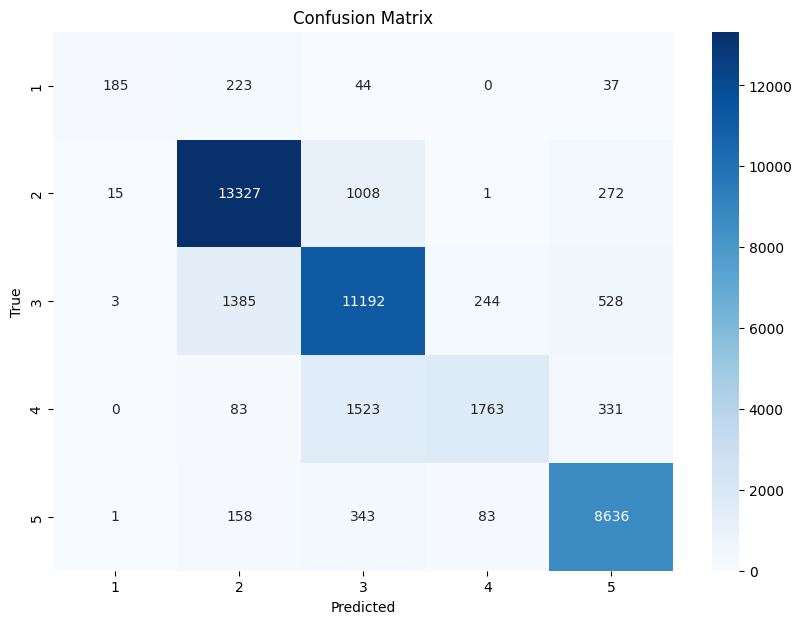

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 6. ROC Curve - Multi-class evaluation (one-vs-rest approach)

# Binarize the output labels for multi-class classification
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

# Get the probability predictions for each class
y_score = lr_pipeline.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the ROC curve for a random classifier (diagonal line)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('ROC Curve for Logistic Regression (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 7. Confusion Matrix

# Generate the confusion matrix for Logistic Regression predictions
cm = confusion_matrix(y_test, lr_pipeline.predict(X_test))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


              precision    recall  f1-score   support

           1       0.82      0.40      0.54       489
           2       0.88      0.92      0.90     14623
           3       0.80      0.84      0.82     13352
           4       0.83      0.52      0.64      3700
           5       0.89      0.93      0.91      9221

    accuracy                           0.86     41385
   macro avg       0.85      0.72      0.76     41385
weighted avg       0.85      0.86      0.85     41385

Top 20 important words for HotelRating prediction:
throughout: 0.035106530524585004
front: 0.027888249433342237
nonsmoking: 0.026117729758036407
self: 0.025724436785200325
hour: 0.022388320856886877
service: 0.016650748012557604
desk: 0.015793569810502964
free: 0.01519042585787143
inroom: 0.015181039916455134
breakfast: 0.014918670261468626
accessible: 0.014347925100773479
wifi: 0.014113754917257783
accessibility: 0.013410433079608453
limitation: 0.013275666024727129
parking: 0.012804749871962309
smokefree

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# 8. Word Cloud for Class 4 (Rating 4)

# Get the coefficients for Logistic Regression (shape: (n_classes, n_features))
lr_importances = lr_pipeline.named_steps['clf'].coef_

# Get the feature names from the TF-IDF vectorizer
words_lr = np.array(tfidf.get_feature_names_out())

# Class index for Class 4 (Rating 4)
class_idx_4 = 3  # Class 4 corresponds to index 3

# Get the sorted indices of the class coefficients (Class 4)
sorted_indices_4 = np.argsort(lr_importances[class_idx_4])[::-1]  # Sort in descending order
top_words_4 = words_lr[sorted_indices_4[:20]]  # Top 20 words
top_importances_4 = lr_importances[class_idx_4][sorted_indices_4[:20]]

# Create a dictionary of words and their importances for word cloud
word_freq_4 = {word: importance for word, importance in zip(top_words_4, top_importances_4)}

# Generate the word cloud for Class 4
wordcloud_4 = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(word_freq_4)

# Plot the word cloud for Class 4
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_4, interpolation='bilinear')
plt.title('Word Cloud for Class 4 (Rating 4)', fontsize=16)
plt.axis('off')
plt.show()


              precision    recall  f1-score   support

           1       0.33      0.00      0.00       489
           2       0.82      0.86      0.84     14623
           3       0.70      0.75      0.73     13352
           4       0.60      0.25      0.35      3700
           5       0.82      0.91      0.86      9221

    accuracy                           0.77     41385
   macro avg       0.65      0.55      0.56     41385
weighted avg       0.76      0.77      0.75     41385



In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# 8. Word Cloud for Class 5 (Rating 5)

# Get the coefficients for Logistic Regression (shape: (n_classes, n_features))
lr_importances = lr_pipeline.named_steps['clf'].coef_

# Get the feature names from the TF-IDF vectorizer
words_lr = np.array(tfidf.get_feature_names_out())

# Class index for Class 5 (Rating 5)
class_idx_5 = 4  # Class 5 corresponds to index 4

# Get the sorted indices of the class coefficients (Class 5)
sorted_indices_5 = np.argsort(lr_importances[class_idx_5])[::-1]  # Sort in descending order
top_words_5 = words_lr[sorted_indices_5[:20]]  # Top 20 words
top_importances_5 = lr_importances[class_idx_5][sorted_indices_5[:20]]

# Create a dictionary of words and their importances for word cloud
word_freq_5 = {word: importance for word, importance in zip(top_words_5, top_importances_5)}

# Generate the word cloud for Class 5
wordcloud_5 = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(word_freq_5)

# Plot the word cloud for Class 5
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_5, interpolation='bilinear')
plt.title('Word Cloud for Class 5 (Rating 5)', fontsize=16)
plt.axis('off')
plt.show()


783
